In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage

In [2]:
# Load CSV files\
df_data = pd.read_csv('pandas/df_data.csv', low_memory=False)
df_filtered = pd.read_csv('pandas/df_filtered.csv')

agg_df = pd.read_csv('pandas/agg_df_cluster.csv')
fish_df = pd.read_csv('pandas/fish_df_cluster.csv')
agg_df_large = pd.read_csv('pandas/agg_df_large_cluster.csv')
fish_df_large = pd.read_csv('pandas/fish_df_large_cluster.csv')

In [26]:
# designate which clustering to analyze
df_explore = agg_df # or agg_df_large
fish_explore = fish_df # or fish_df_large


Cluster sizes:
cluster
1     2134
2      218
3       19
4       10
5        5
6        5
7        4
9        3
8        3
10       2
11       2
12       2
13       1
14       1
15       1
16       1
17       1
dtype: int64


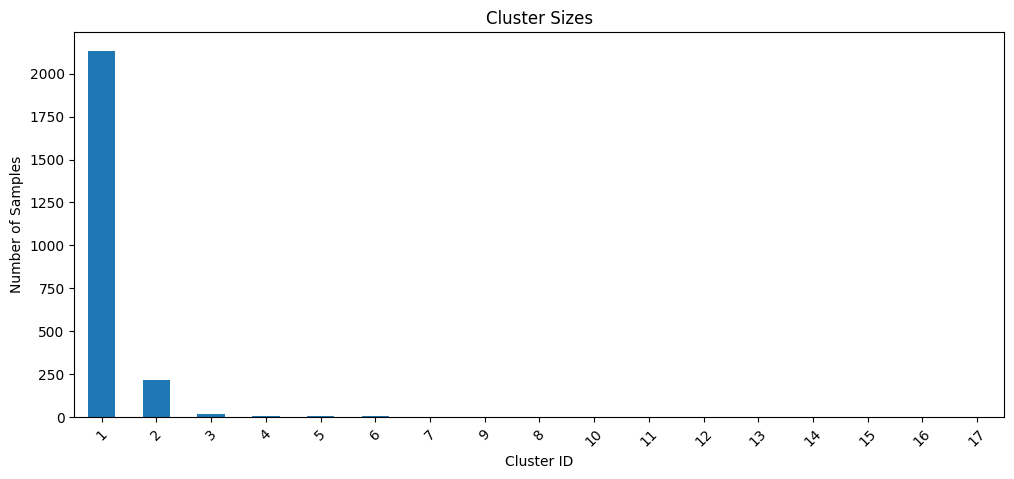

In [27]:
# Summary of clusters
cluster_summary = df_explore.groupby('cluster').size().sort_values(ascending=False)
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title('Cluster Sizes')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

In [28]:
# Specify cluster to analyze
cluster_num = 1

# Filter data for this cluster
cluster_data = df_explore[df_explore['cluster'] == cluster_num]
cluster_fish_data = df_filtered[df_filtered['barcode'].isin(cluster_data['barcode'])]

# Environmental variables summary (median)
env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
env_summary = cluster_data[env_vars].median()

# Categorical variables summary (mode)
cat_vars = ['mode_substrt']
cat_summary = cluster_data[cat_vars].mode().iloc[0]

# Binary variables summary (proportion present)
binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
binary_summary = cluster_data[binary_vars].mean()

# Fish species counts
fish_in_cluster = fish_explore[df_explore['cluster'] == cluster_num].drop(columns=['cluster'])
species_counts = fish_in_cluster.sum().sort_values(ascending=False)
species_counts = species_counts[species_counts > 0]

cluster_barcodes = df_explore[df_explore['cluster'] == cluster_num]['barcode']

# Total individuals caught
fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
#fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

# Number of samples where present
fish_occurrence = fish_in_cluster.sum()

# Combine
species_summary = pd.DataFrame({
    'total_caught': fish_abundance,
    'samples': fish_occurrence,
    'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
}).fillna(0).astype({'total_caught': int, 'samples': int})
species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)

# Print summary
print(f"=== CLUSTER {cluster_num} SUMMARY ===")
print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
print("\n--- Environmental Variables (Median) ---")
print(env_summary)
print("\n--- Categorical Variables (Mode) ---")
print(cat_summary)
print("\n--- Binary Variables (Proportion Present) ---")
print(binary_summary)
print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
print(species_summary)

=== CLUSTER 1 SUMMARY ===

Total samples (identified by barcode): 2134

--- Environmental Variables (Median) ---
median_temp        14.70
median_depth        1.00
median_current      0.07
median_esveg92      1.00
median_cond       392.00
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    3.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.663996
riprap_present     0.179076
inout_present      0.057022
flooded_present    0.117813
dtype: float64

--- Fish Species (Count of 2134 samples) ---
      total_caught  samples  mean_length
LMBS         21469     1809        180.1
BLGL         21016     1796         98.1
ERSN          6358     1461         53.1
CARP          8401     1242        536.4
GZSD          7157     1119        142.4
...            ...      ...          ...
SJHR             1        1         50.0
SHCB             1        1         30.0
LSSR             1        1         79.0
HHCB             1        1        

In [29]:
# Summarize all clusters at once
for cluster_num in sorted(df_explore['cluster'].unique()):
    cluster_data = df_explore[df_explore['cluster'] == cluster_num]
    cluster_fish_data = df_data[df_data['barcode'].isin(cluster_data['barcode'])]
    
    # Environmental variables summary (median)
    env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
    env_summary = cluster_data[env_vars].median()

    # Categorical variables summary (mode)
    cat_vars = ['mode_substrt']
    cat_summary = cluster_data[cat_vars].mode().iloc[0]

    # Binary variables summary (proportion present)
    binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
    binary_summary = cluster_data[binary_vars].mean()

    # Fish species counts
    fish_in_cluster = fish_explore[df_explore['cluster'] == cluster_num].drop(columns=['cluster'])
    species_counts = fish_in_cluster.sum().sort_values(ascending=False)
    species_counts = species_counts[species_counts > 0]

    cluster_barcodes = df_explore[df_explore['cluster'] == cluster_num]['barcode']

    # Total individuals caught
    fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
    fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
    #fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

    # Number of samples where present
    fish_occurrence = fish_in_cluster.sum()

    # Combine
    species_summary = pd.DataFrame({
        'total_caught': fish_abundance,
        'samples': fish_occurrence,
        'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
    }).fillna(0).astype({'total_caught': int, 'samples': int})
    species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)


    # Print summary
    print(f"=== CLUSTER {cluster_num} SUMMARY ===")
    print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
    print("\n--- Environmental Variables (Median) ---")
    print(env_summary)
    print("\n--- Categorical Variables (Mode) ---")
    print(cat_summary)
    print("\n--- Binary Variables (Proportion Present) ---")
    print(binary_summary)
    print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
    print(species_summary)

=== CLUSTER 1 SUMMARY ===

Total samples (identified by barcode): 2134

--- Environmental Variables (Median) ---
median_temp        14.70
median_depth        1.00
median_current      0.07
median_esveg92      1.00
median_cond       392.00
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    3.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.663996
riprap_present     0.179076
inout_present      0.057022
flooded_present    0.117813
dtype: float64

--- Fish Species (Count of 2134 samples) ---
      total_caught  samples  mean_length
LMBS         21469     1809        180.1
BLGL         21016     1796         98.1
ERSN          6358     1461         53.1
CARP          8401     1242        536.4
GZSD          7157     1119        142.4
...            ...      ...          ...
SJHR             1        1         50.0
SHCB             1        1         30.0
LSSR             1        1         79.0
HHCB             1        1        

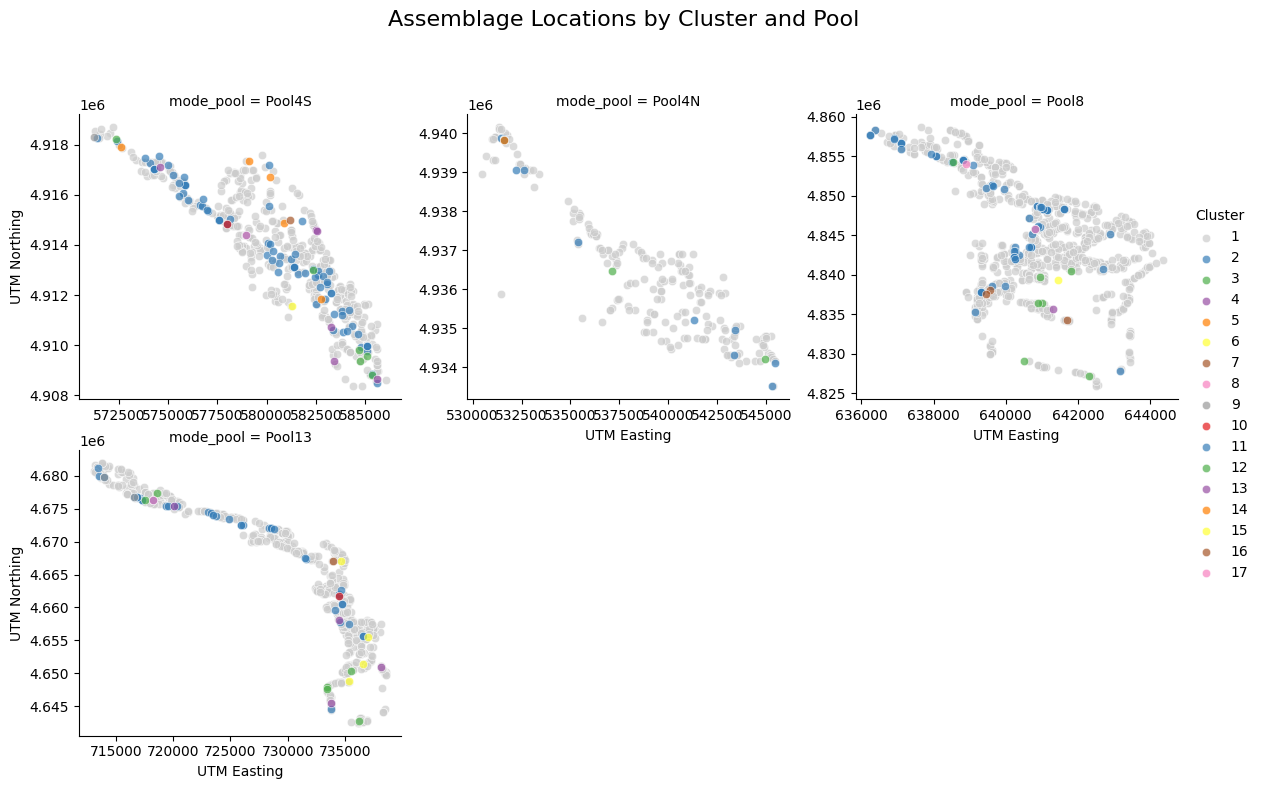

In [30]:
# Find the cluster with the largest count
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = df_explore['cluster'].value_counts().idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
size_map = {c: f"{cluster_sizes[c]} sites" for c in unique_clusters}
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {c: col for c, col in zip(unique_clusters, palette)}
color_map[largest_cluster] = light_color

g = sns.FacetGrid(
    df_explore,
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=3,
    height=4,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Assemblage Locations by Cluster and Pool", fontsize=16)
plt.show()

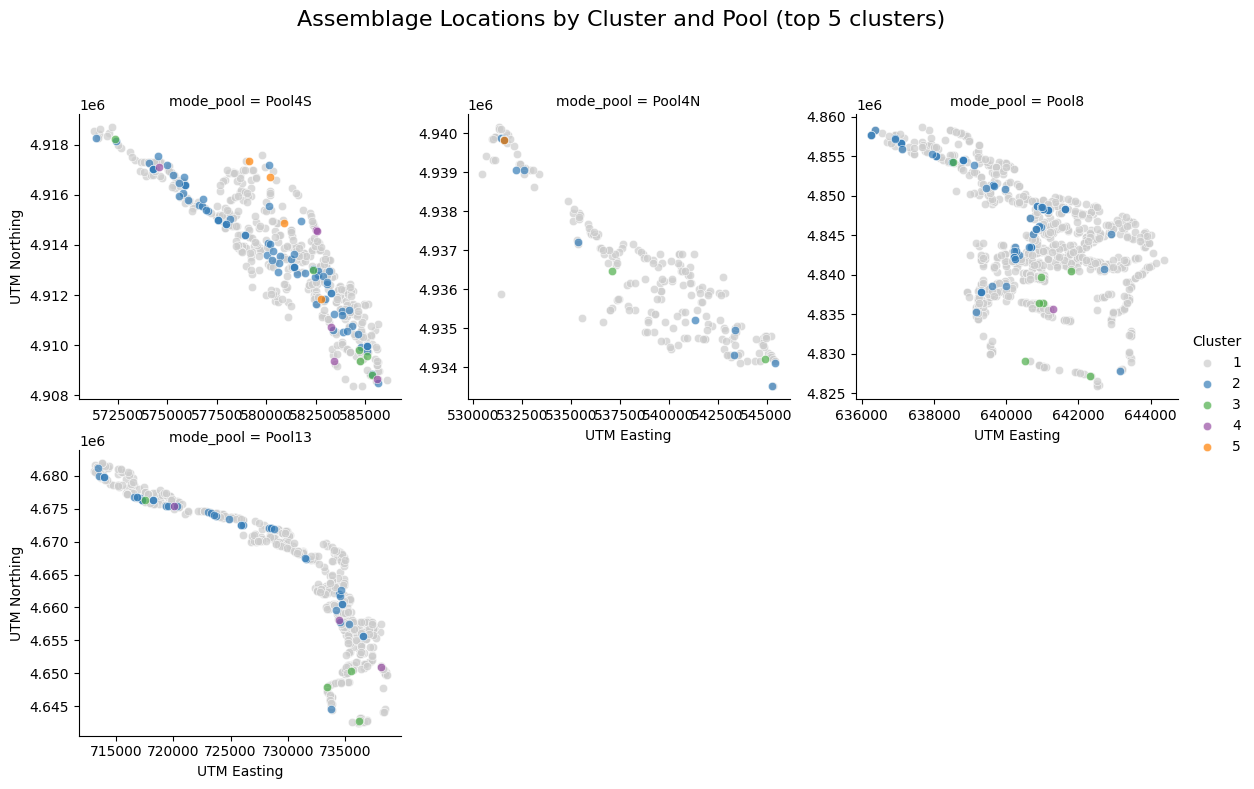

In [31]:
# Find the cluster with the largest count
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = df_explore['cluster'].value_counts().idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
size_map = {c: f"{cluster_sizes[c]} sites" for c in unique_clusters}
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {c: col for c, col in zip(unique_clusters, palette)}
color_map[largest_cluster] = light_color

g = sns.FacetGrid(
    df_explore[df_explore['cluster'].isin(range(6))],
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=3,
    height=4,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Assemblage Locations by Cluster and Pool (top 5 clusters)", fontsize=16)
plt.show()

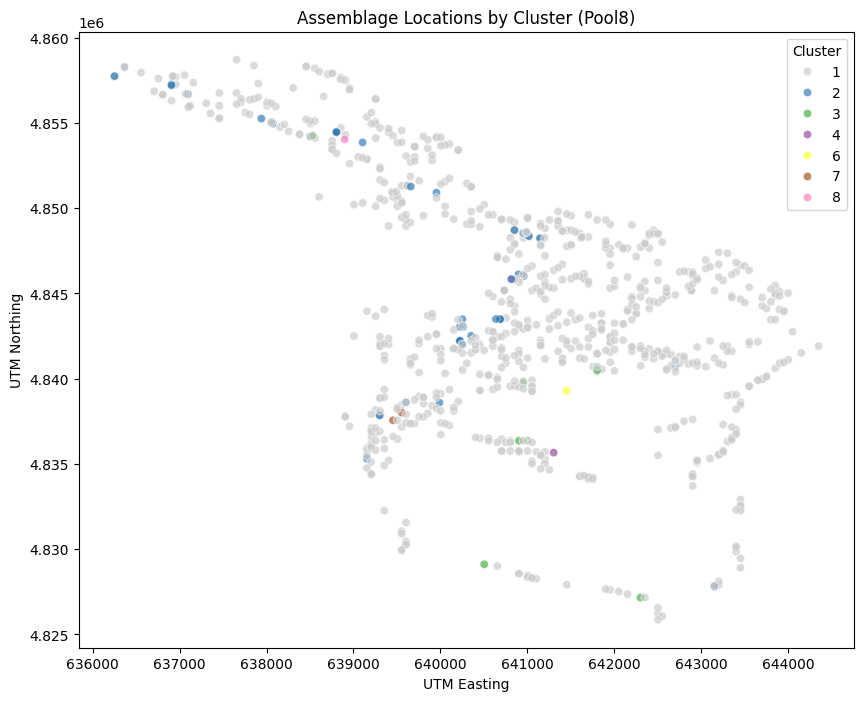

In [32]:
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = cluster_sizes.idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {c: col for c, col in zip(unique_clusters, palette)}
color_map[largest_cluster] = light_color

#####
# Filter by specified pool
#####
pool_filter = 'Pool8'  # Change this to desired pool value
available_pools = sorted(df_explore['mode_pool'].unique().tolist())

if pool_filter not in available_pools:
    print(f"No rows for mode_pool == {pool_filter}. Available pools: {available_pools}")
else:
    df_pool = df_explore[df_explore['mode_pool'] == pool_filter].copy()

    # Plot using the same color_map as the global plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_pool,
        x="utm_e",
        y="utm_n",
        hue="cluster",
        palette=color_map,
        alpha=0.7
    )
    plt.xlabel("UTM Easting")
    plt.ylabel("UTM Northing")
    plt.title(f"Assemblage Locations by Cluster ({pool_filter})")
    plt.legend(title="Cluster")
    plt.show()

## <a id='toc2_2_'></a>[Cluster Characteristics](#toc0_)

We next inspected how each cluster varied in it’s species composition.

We will produce three vertical heatmaps for the Jaccard clustering method. Each heatmap shows the average percent presence of each fish species (rows) within each cluster (columns).

*What the graph means:*

-   **Columns**: Each column is a cluster of assemblages (sites grouped by fish community similarity).
-   **Rows**: Each row is a fish species (only those present in >10% of any cluster).
-   **Cell values**: The number in each cell is the percent of assemblages in that cluster where the species is present (0–100%).
-   **Color**: Darker blue = higher percent presence.
-   **Interpretation**: You can see which species are common or rare in each cluster, and how species composition differs between clusters and clustering methods.

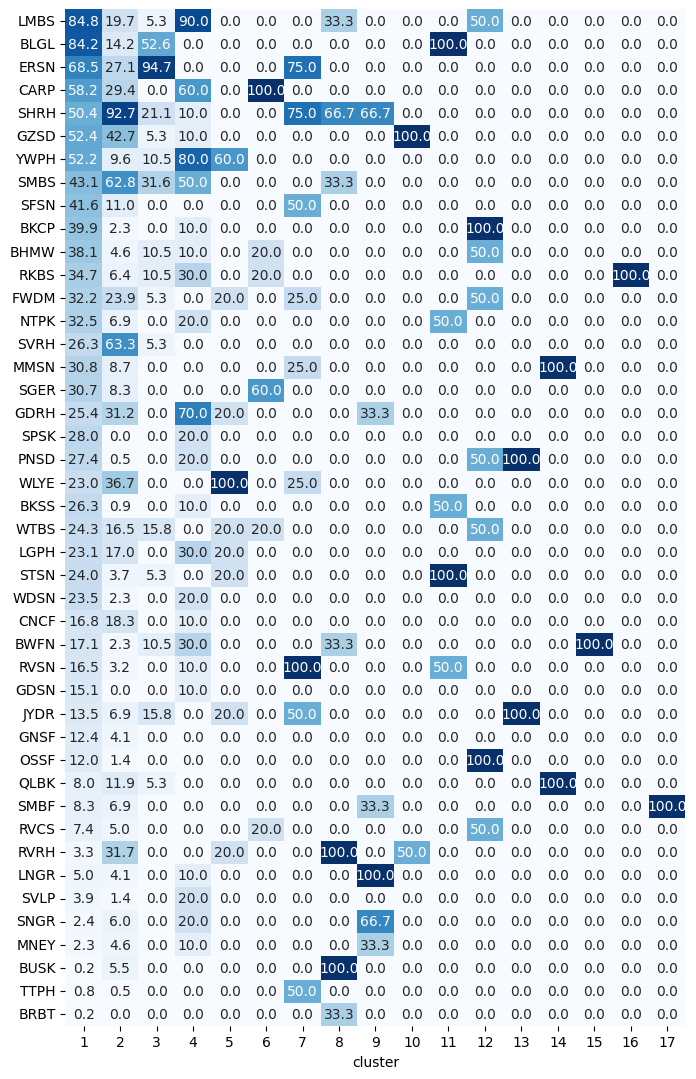

<Figure size 640x480 with 0 Axes>

In [33]:
# Order species by overall frequency of occurrence (sum across columns)
species_cols = [c for c in fish_explore.columns if c != 'cluster']
species_order = fish_explore[species_cols].sum(axis=0).sort_values(ascending=False).index.tolist()

# Compute percent presence per cluster
jac_comp = fish_explore.groupby('cluster')[species_order].mean() * 100

# Keep species present in >10% of at least one cluster
filt = jac_comp.max() > 10
jac_comp = jac_comp.loc[:, filt]

# Plot heatmap (species as rows)
plt.figure(figsize=(8, 0.3 * jac_comp.shape[1]))
sns.heatmap(jac_comp.T, cmap='Blues', annot=True, fmt=".1f", cbar=False)
plt.show()
plt.savefig('cluster_heatmap.png', dpi=300, bbox_inches='tight')

## Clusters over time

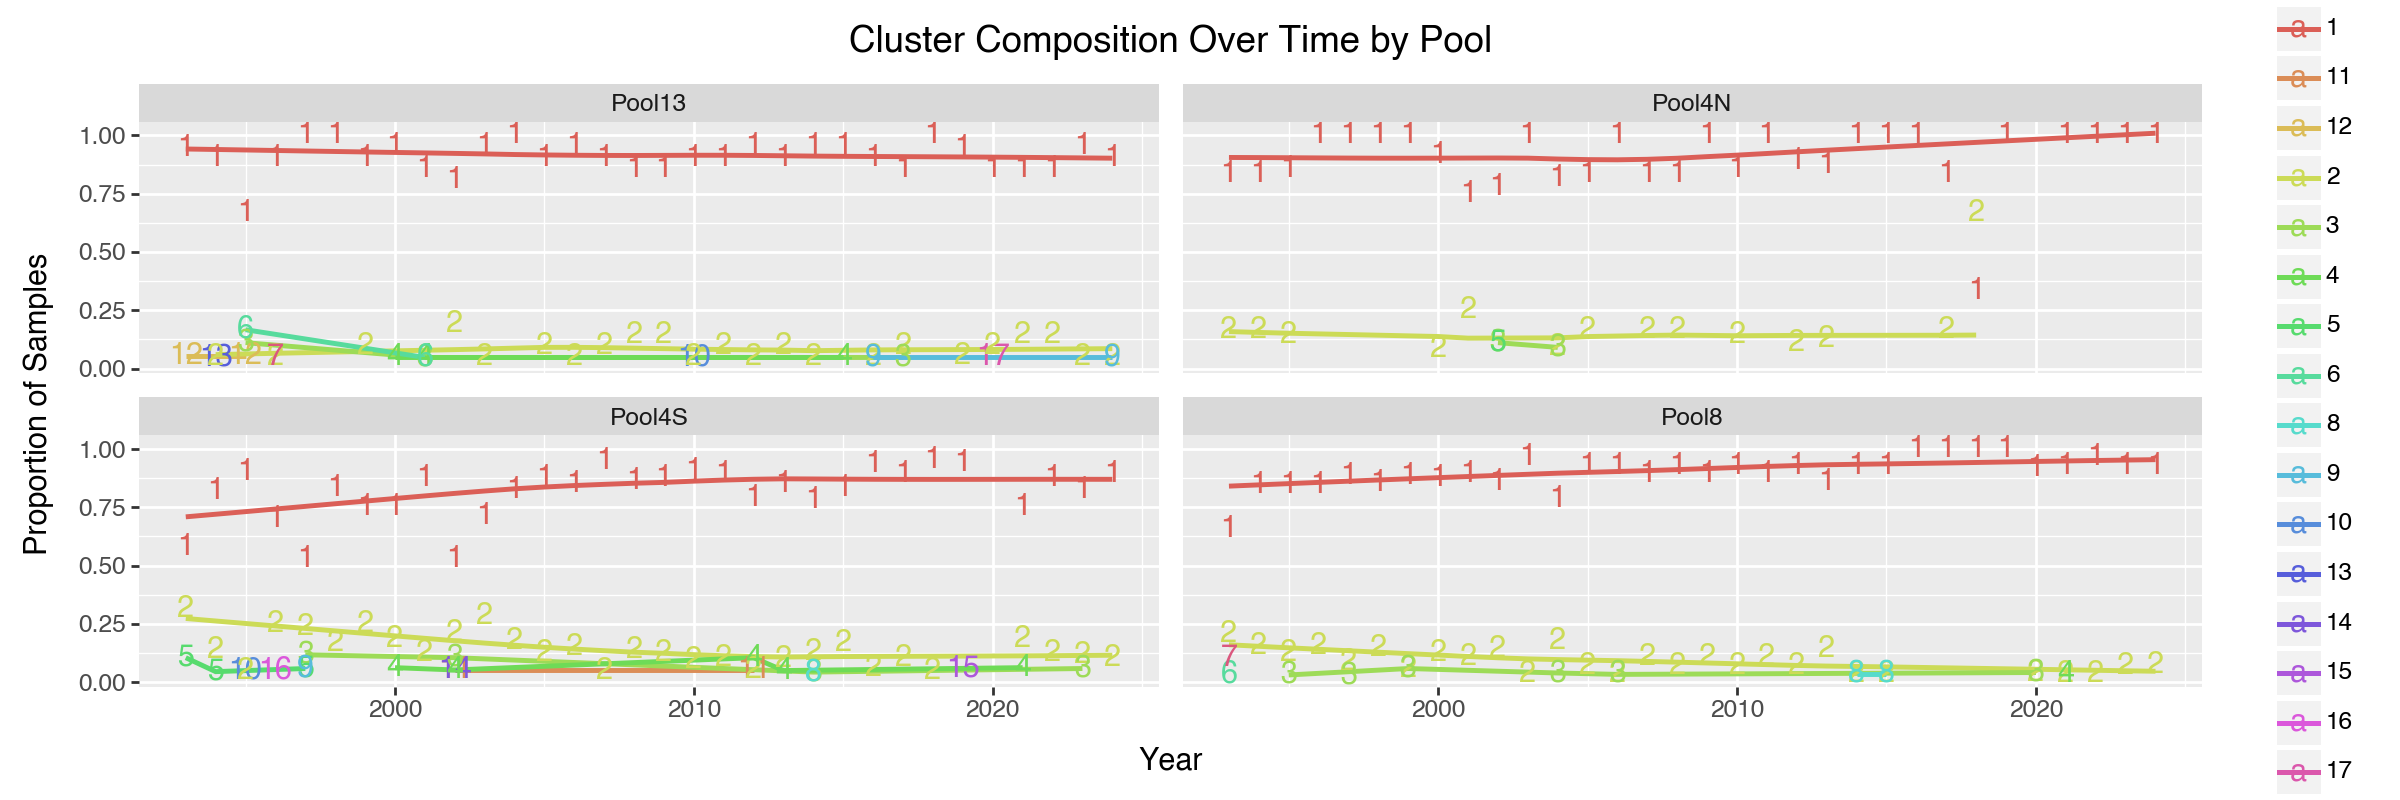

In [20]:
from plotnine import *

# Calculate proportion of samples in each cluster per year
cluster_time = df_explore.groupby(['year', 'cluster']).size().reset_index(name='count')
total_per_year = cluster_time.groupby('year')['count'].transform('sum')
cluster_time['proportion'] = cluster_time['count'] / total_per_year
cluster_time['cluster'] = cluster_time['cluster'].astype(str)

# Plot proportion per year (not count)
(ggplot(cluster_time, aes(x='year', y='proportion', color='cluster')) +
 geom_line() +
 geom_point() +
 labs(x='Year', y='Proportion of Samples', color='Cluster', title='Cluster Composition Over Time')
 )

# Calculate proportion per year per cluster per pool
cluster_time_pool = df_explore.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
total_per_year_pool = cluster_time_pool.groupby(['year', 'mode_pool'])['count'].transform('sum')
cluster_time_pool['proportion'] = cluster_time_pool['count'] / total_per_year_pool
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Only smooth groups with >= 2 points
grp_size = cluster_time_pool.groupby(['mode_pool', 'cluster'])['year'].transform('size')
cluster_time_pool_smooth = cluster_time_pool[grp_size >= 2]

# Faceted plot with smoothing (proportion)
(ggplot(cluster_time_pool, aes(x='year', y='proportion', color='cluster')) +
 geom_line() +
 geom_point() +
 geom_smooth(data=cluster_time_pool_smooth, method='lm', se=False) +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Proportion of Samples', color='Cluster', title='Cluster Composition Over Time by Pool')
 )

# Filter out a cluster and plot with labels, smoothing only for groups with >= 2 points
filtered = cluster_time_pool.query('cluster != "19"')
grp_size2 = filtered.groupby(['mode_pool', 'cluster'])['year'].transform('size')
filtered_smooth = filtered[grp_size2 >= 2]

(ggplot(filtered, aes(x='year', y='proportion', color='cluster')) +
 geom_point() +
 geom_text(aes(label='cluster')) +
 geom_smooth(data=filtered_smooth, method='lm', se=False) +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Proportion of Samples', color='Cluster', title='Cluster Composition Over Time by Pool') +
 theme(figure_size=(12, 4))
 )

# Create the plot with faceting by pool (proportion)
(ggplot(cluster_time_pool.query('cluster != "19"'), aes(x='year', y='proportion', color='cluster')) +
 #geom_line() +
 #geom_point() +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Proportion of Samples', color='Cluster', 
    title='Cluster Composition Over Time by Pool') +
 geom_smooth(data=filtered_smooth, method = 'lowess', se=False) +
 geom_text(aes(label='cluster')) +
 #scale_y_log10() +
 theme(figure_size=(12, 4))  # width=12, height=4 inches
 )

/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic h

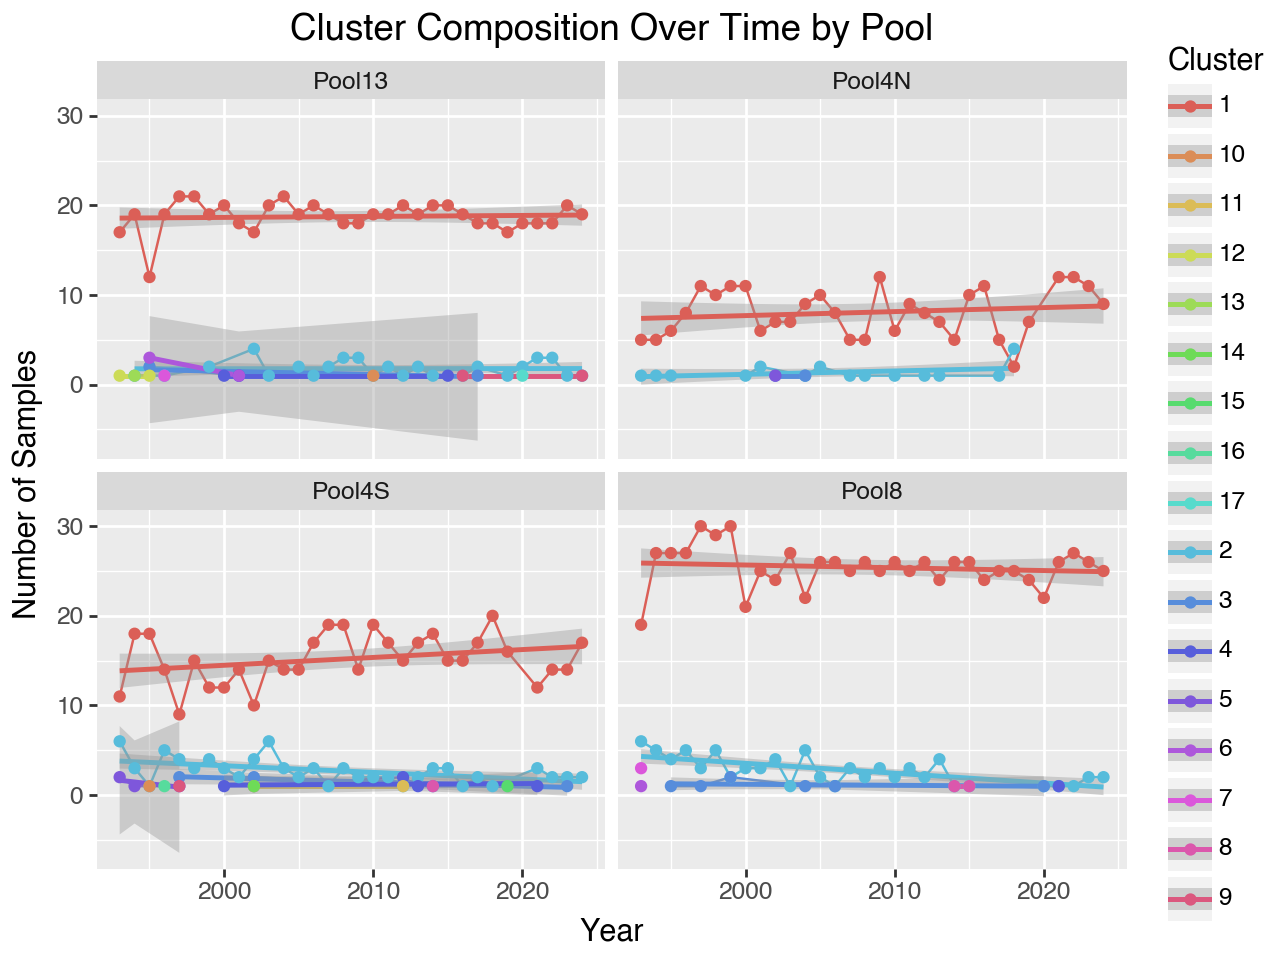

In [23]:
from plotnine import *

# Count samples per year per cluster per pool
cluster_time_pool = df_explore.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Create the plot with faceting by pool
(ggplot(cluster_time_pool, aes(x='year', y='count', color='cluster')) +
 geom_line() +
 geom_smooth(method = 'lm') +
 geom_point() +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Number of Samples', color='Cluster', 
    title='Cluster Composition Over Time by Pool') 
    #+
 #scale_y_log10()
 )

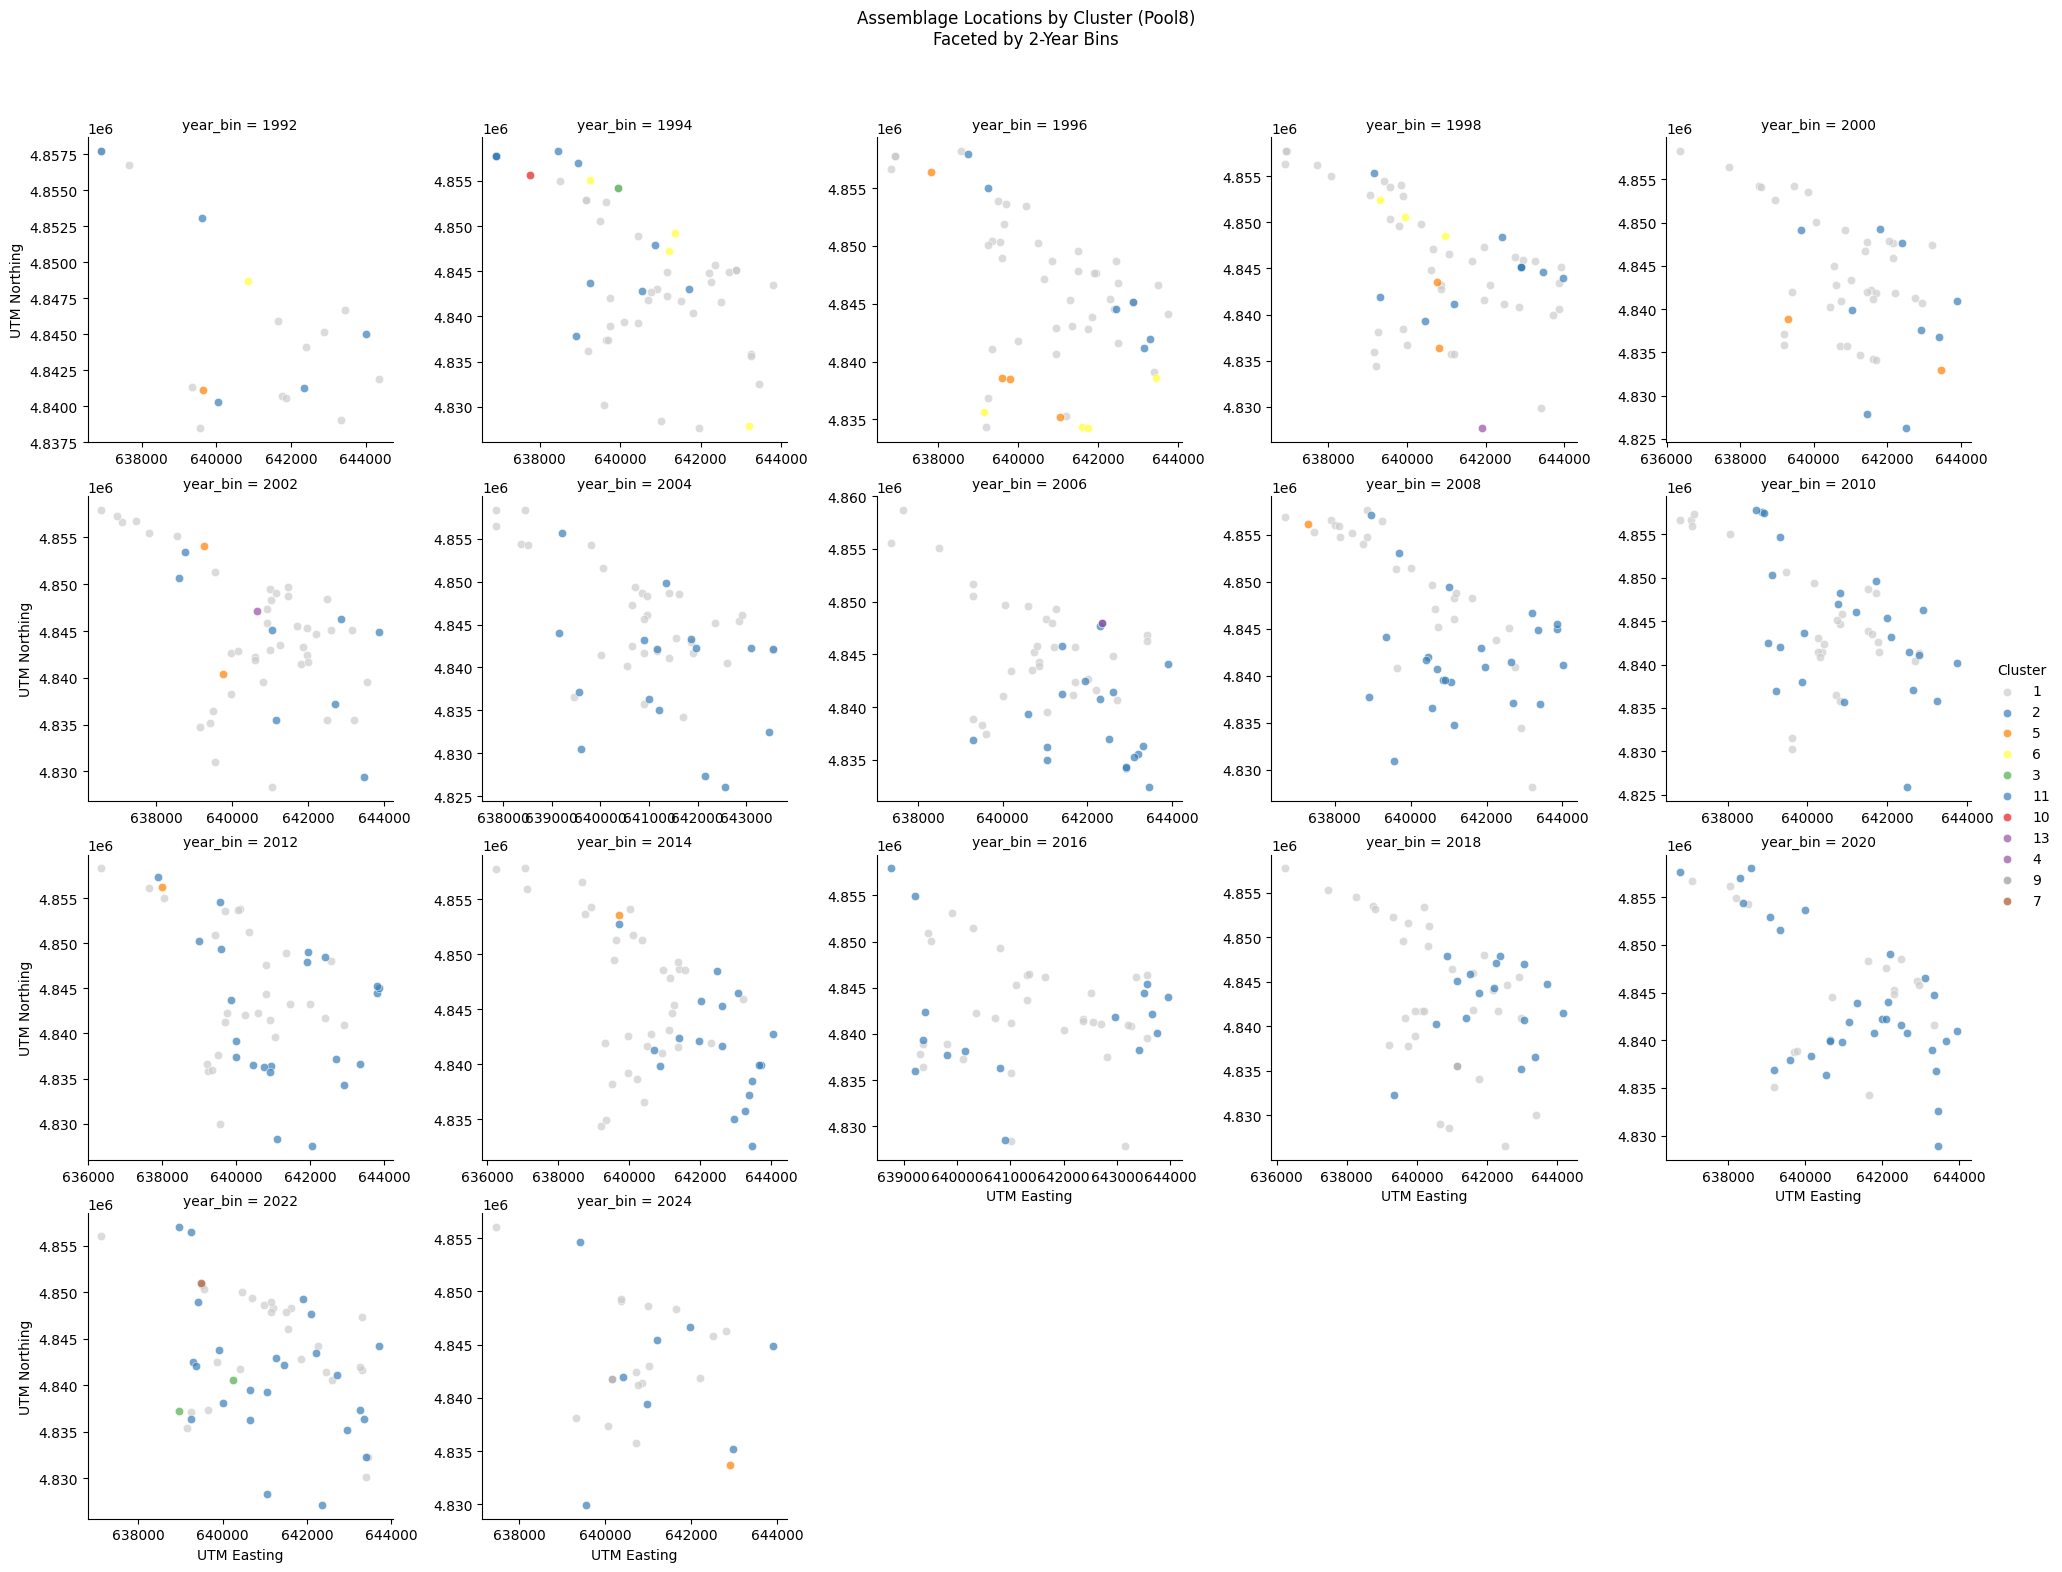

In [234]:
# Use the same color_map as the global plot
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = cluster_sizes.idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {str(c): col for c, col in zip(unique_clusters, palette)}
color_map[str(largest_cluster)] = light_color

if pool_filter not in available_pools:
    print(f"No rows for mode_pool == {pool_filter}. Available pools: {available_pools}")
else:
    df_pool = df_explore[df_explore['mode_pool'] == pool_filter].copy()
    
    YEAR_BIN = 2
    # Create a new column for year bins
    df_pool['year_bin'] = ((df_pool['year']) // YEAR_BIN) * YEAR_BIN

    # Ensure cluster column is string type for consistency (optional, for legend order)
    df_pool['cluster'] = df_pool['cluster'].astype(str)

    # Create the FacetGrid using the global color_map
    g = sns.FacetGrid(
        df_pool,
        col="year_bin",
        col_wrap=5,
        height=4,
        sharex=False,
        sharey=False,
        hue="cluster",
        palette=color_map  # Use global color map for consistency
    )
    g.map_dataframe(
        sns.scatterplot,
        x="utm_e",
        y="utm_n",
        alpha=0.7
    )
    g.add_legend(title="Cluster")
    g.set_axis_labels("UTM Easting", "UTM Northing")
    g.figure.subplots_adjust(top=0.9)
    g.figure.suptitle(f"Assemblage Locations by Cluster ({pool_filter})\nFaceted by {YEAR_BIN}-Year Bins")
    plt.show()


DFA for proportion of samples in each cluster over time, faceted by pool.

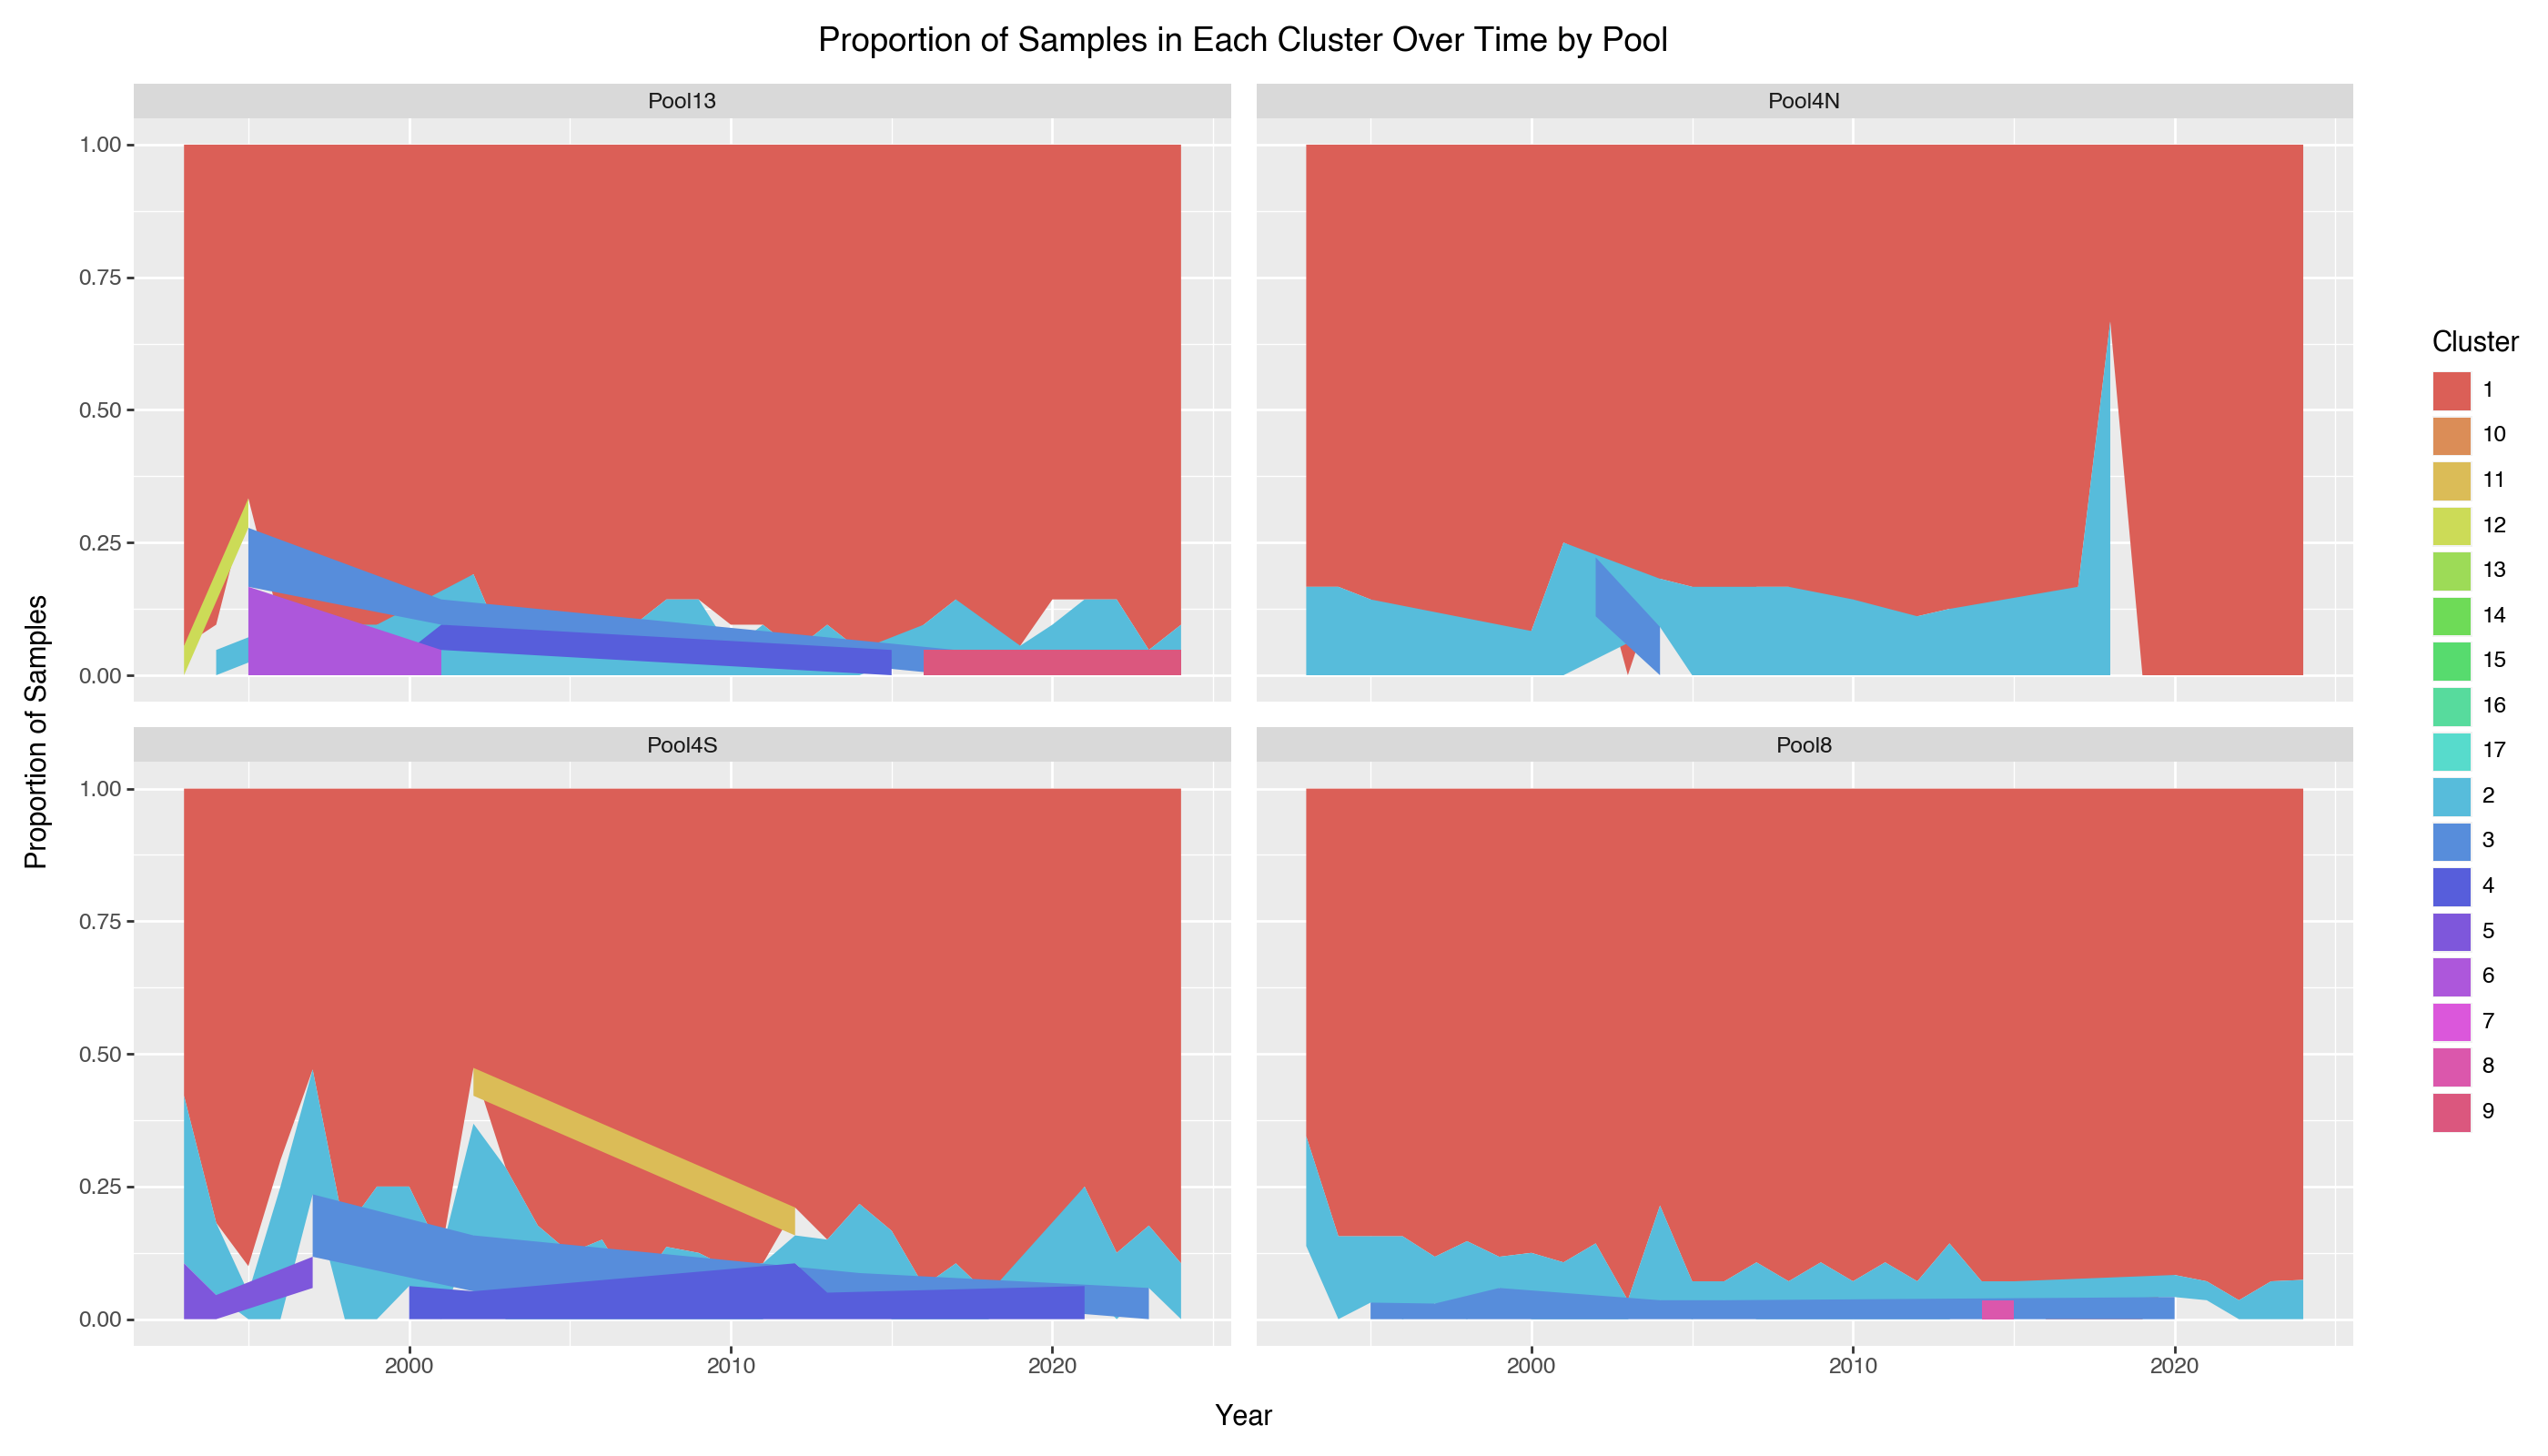

In [24]:
# Prepare data for DFA-style analysis: proportion of samples in each cluster over time by pool
cluster_proportions = df_explore.groupby(['year', 'mode_pool', 'cluster']).size().reset_index(name='count')

# Calculate total samples per year per pool
totals = cluster_proportions.groupby(['year', 'mode_pool'])['count'].transform('sum')
cluster_proportions['proportion'] = cluster_proportions['count'] / totals

# Convert cluster to string for plotting
cluster_proportions['cluster'] = cluster_proportions['cluster'].astype(str)

# Create stacked area plot showing proportions over time, faceted by pool
(ggplot(cluster_proportions, aes(x='year', y='proportion', fill='cluster')) +
 geom_area(position='stack') +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Proportion of Samples', fill='Cluster', 
    title='Proportion of Samples in Each Cluster Over Time by Pool') +
 theme(figure_size=(14, 8))
)

/var/folders/5f/8wj2hdcx4p14q972y40gpgpc0000gn/T/ipykernel_6921/1790906780.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


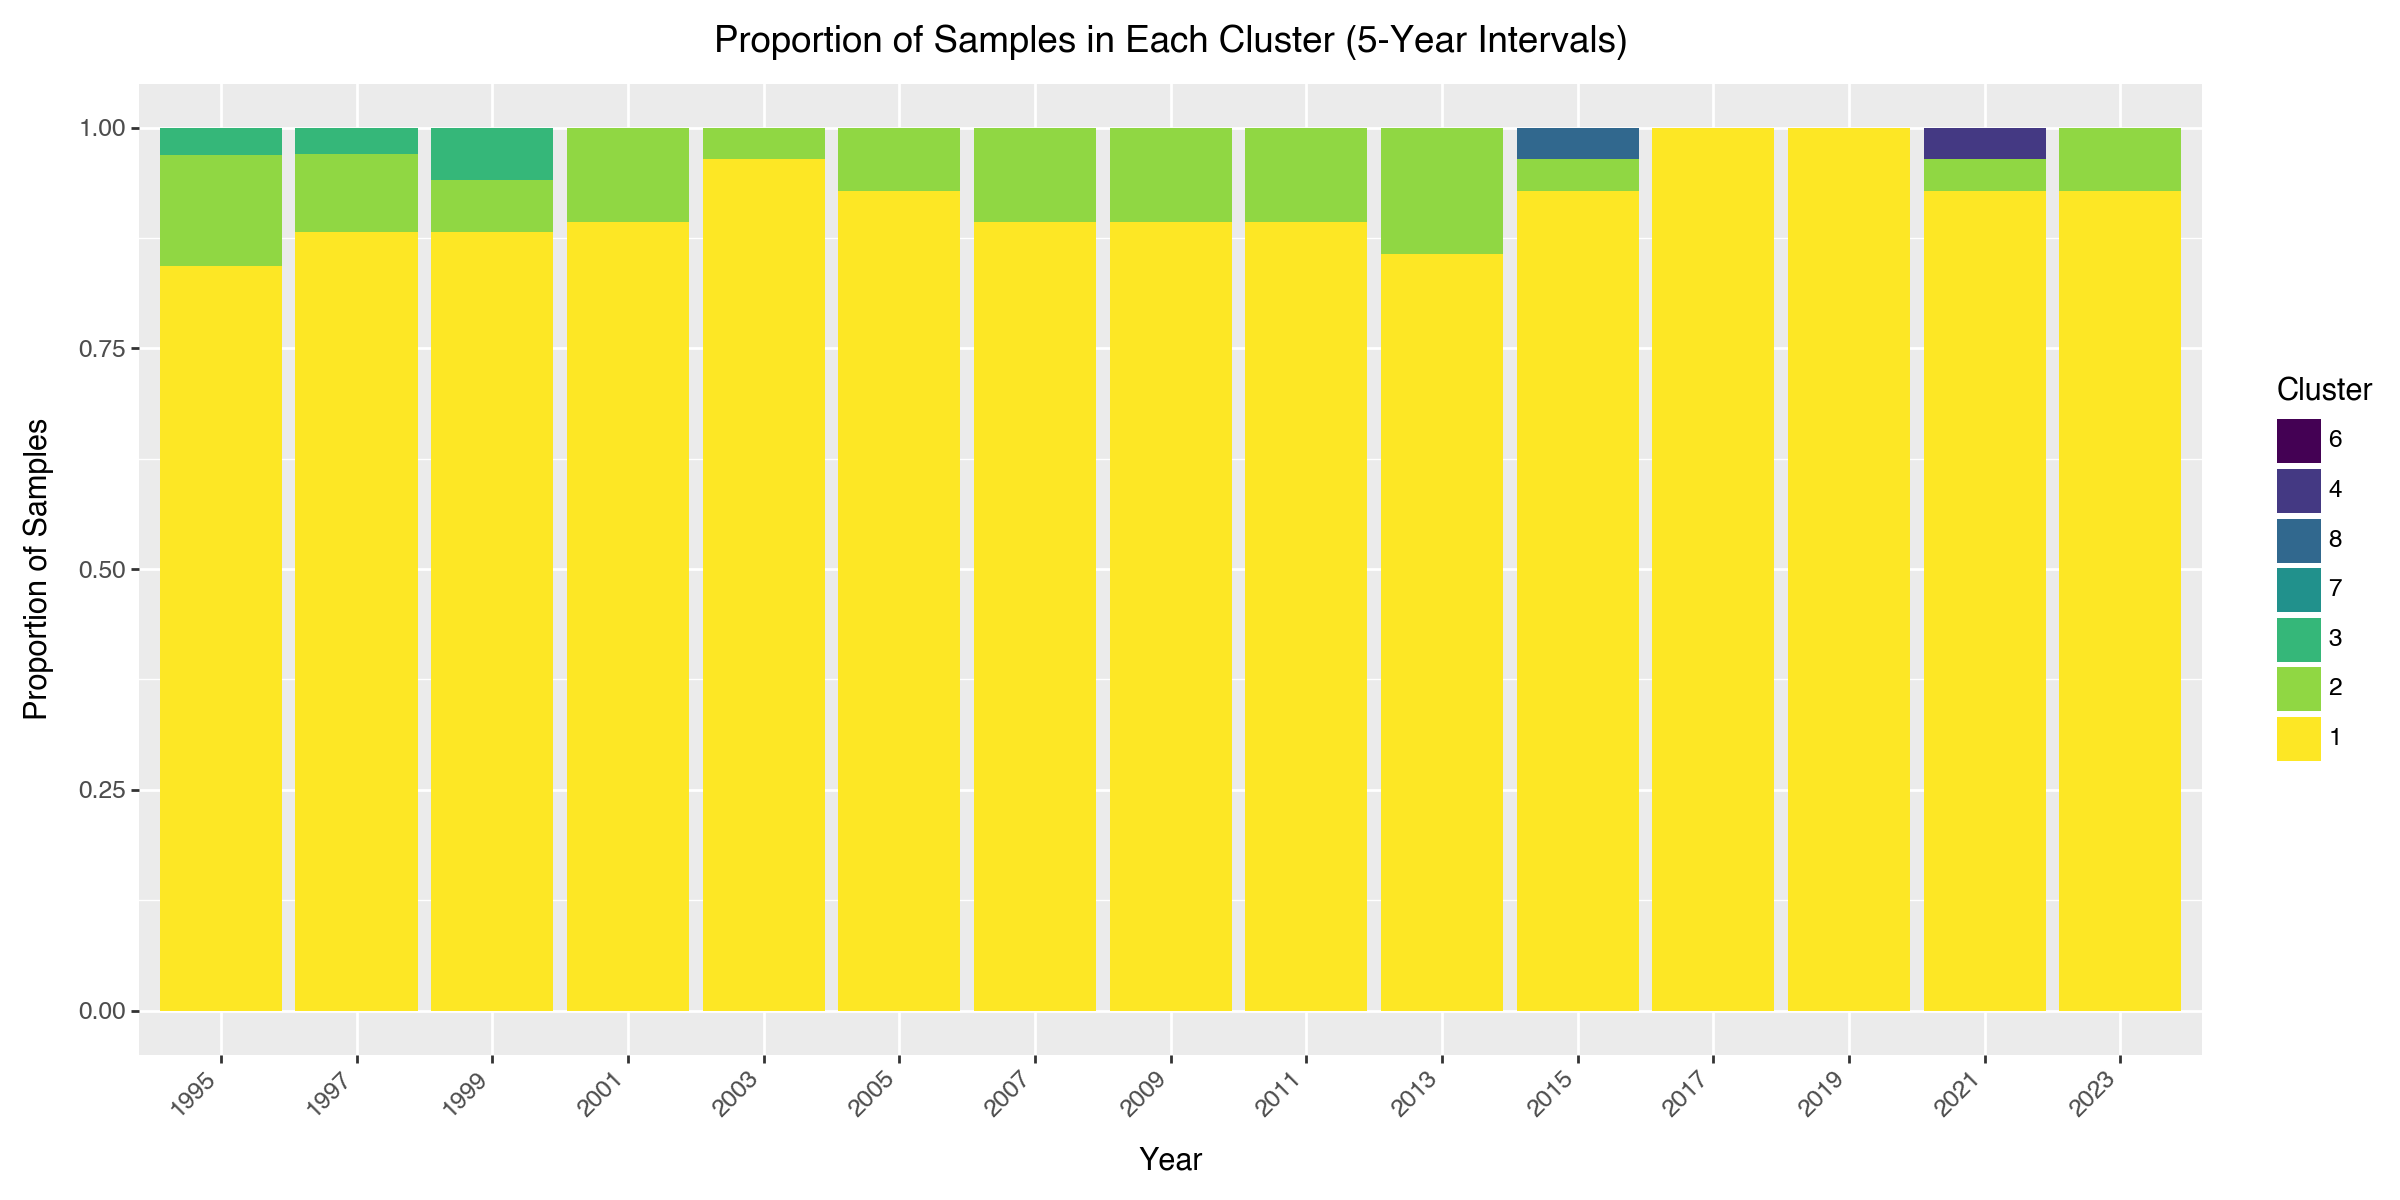

In [25]:
# Prepare data for DFA-style analysis: proportion of samples in each cluster over time by pool
cluster_proportions = df_pool.groupby(['year', 'cluster']).size().reset_index(name='count')

# Calculate total samples per year per pool
totals = cluster_proportions.groupby(['year'])['count'].transform('sum')
cluster_proportions['proportion'] = cluster_proportions['count'] / totals


# Create a filtered dataset for specific years (1995, 2000, 2005, ...)
years_to_plot = list(range(1995, df_pool['year'].max() + 1, 2))

# Filter cluster_proportions for these years
cluster_proportions_filtered = cluster_proportions[cluster_proportions['year'].isin(years_to_plot)]

# Sort clusters by overall proportion (to create consistent ordering)
cluster_order = cluster_proportions.groupby('cluster')['proportion'].sum().sort_values(ascending=True).index.astype(str)

# Ensure cluster is string and convert to categorical with specified order
cluster_proportions_filtered['cluster'] = pd.Categorical(
    cluster_proportions_filtered['cluster'].astype(str),
    categories=cluster_order,
    ordered=True
)

# Create stacked bar plot
(ggplot(cluster_proportions_filtered, aes(x='factor(year)', y='proportion', fill='cluster')) +
 geom_col(position='stack') +
 labs(x='Year', y='Proportion of Samples', fill='Cluster', 
      title='Proportion of Samples in Each Cluster (5-Year Intervals)') +
 theme(figure_size=(12, 6), axis_text_x=element_text(angle=45, hjust=1))
)

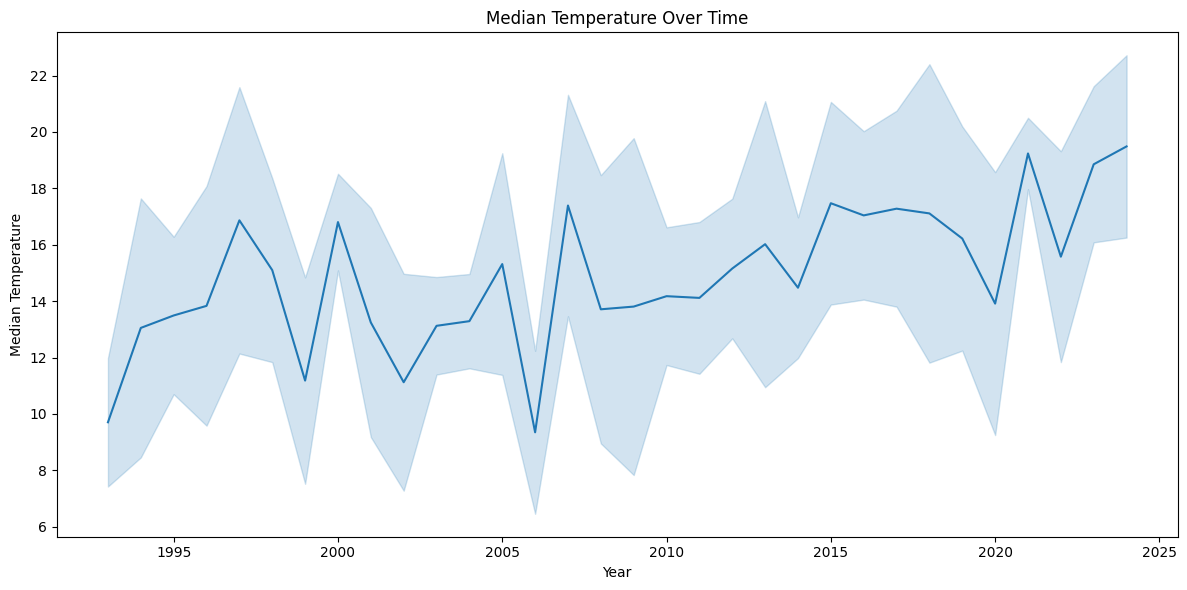

In [144]:
# Plot median temperature over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pool, x='year', y='median_temp', estimator='mean', errorbar='sd')
plt.xlabel('Year')
plt.ylabel('Median Temperature')
plt.title('Median Temperature Over Time')
plt.tight_layout()
plt.show()

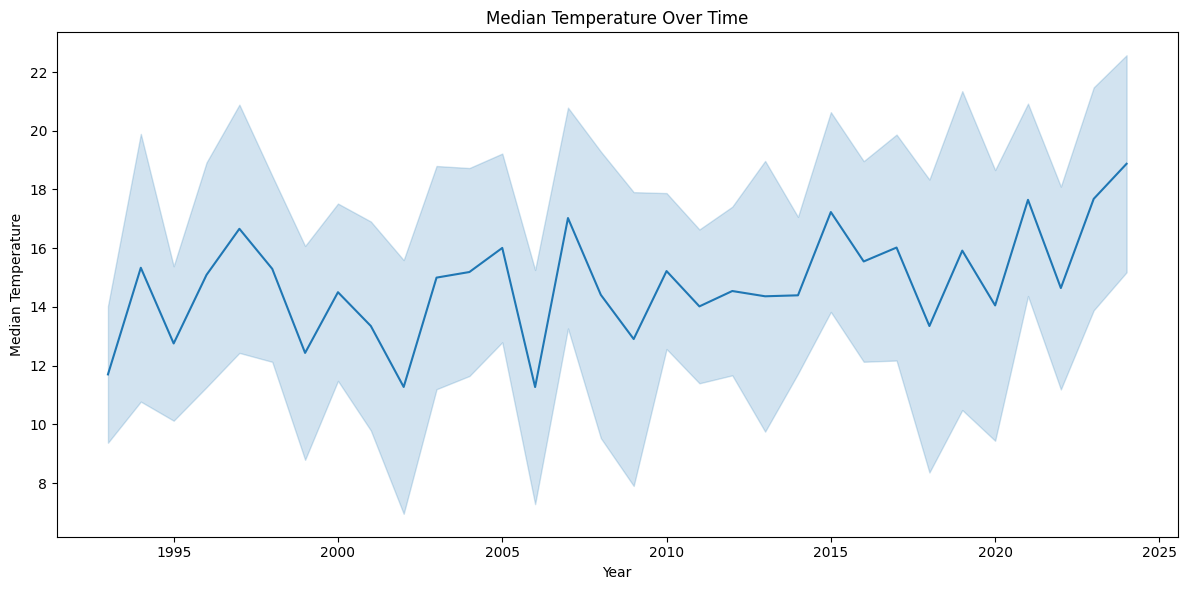

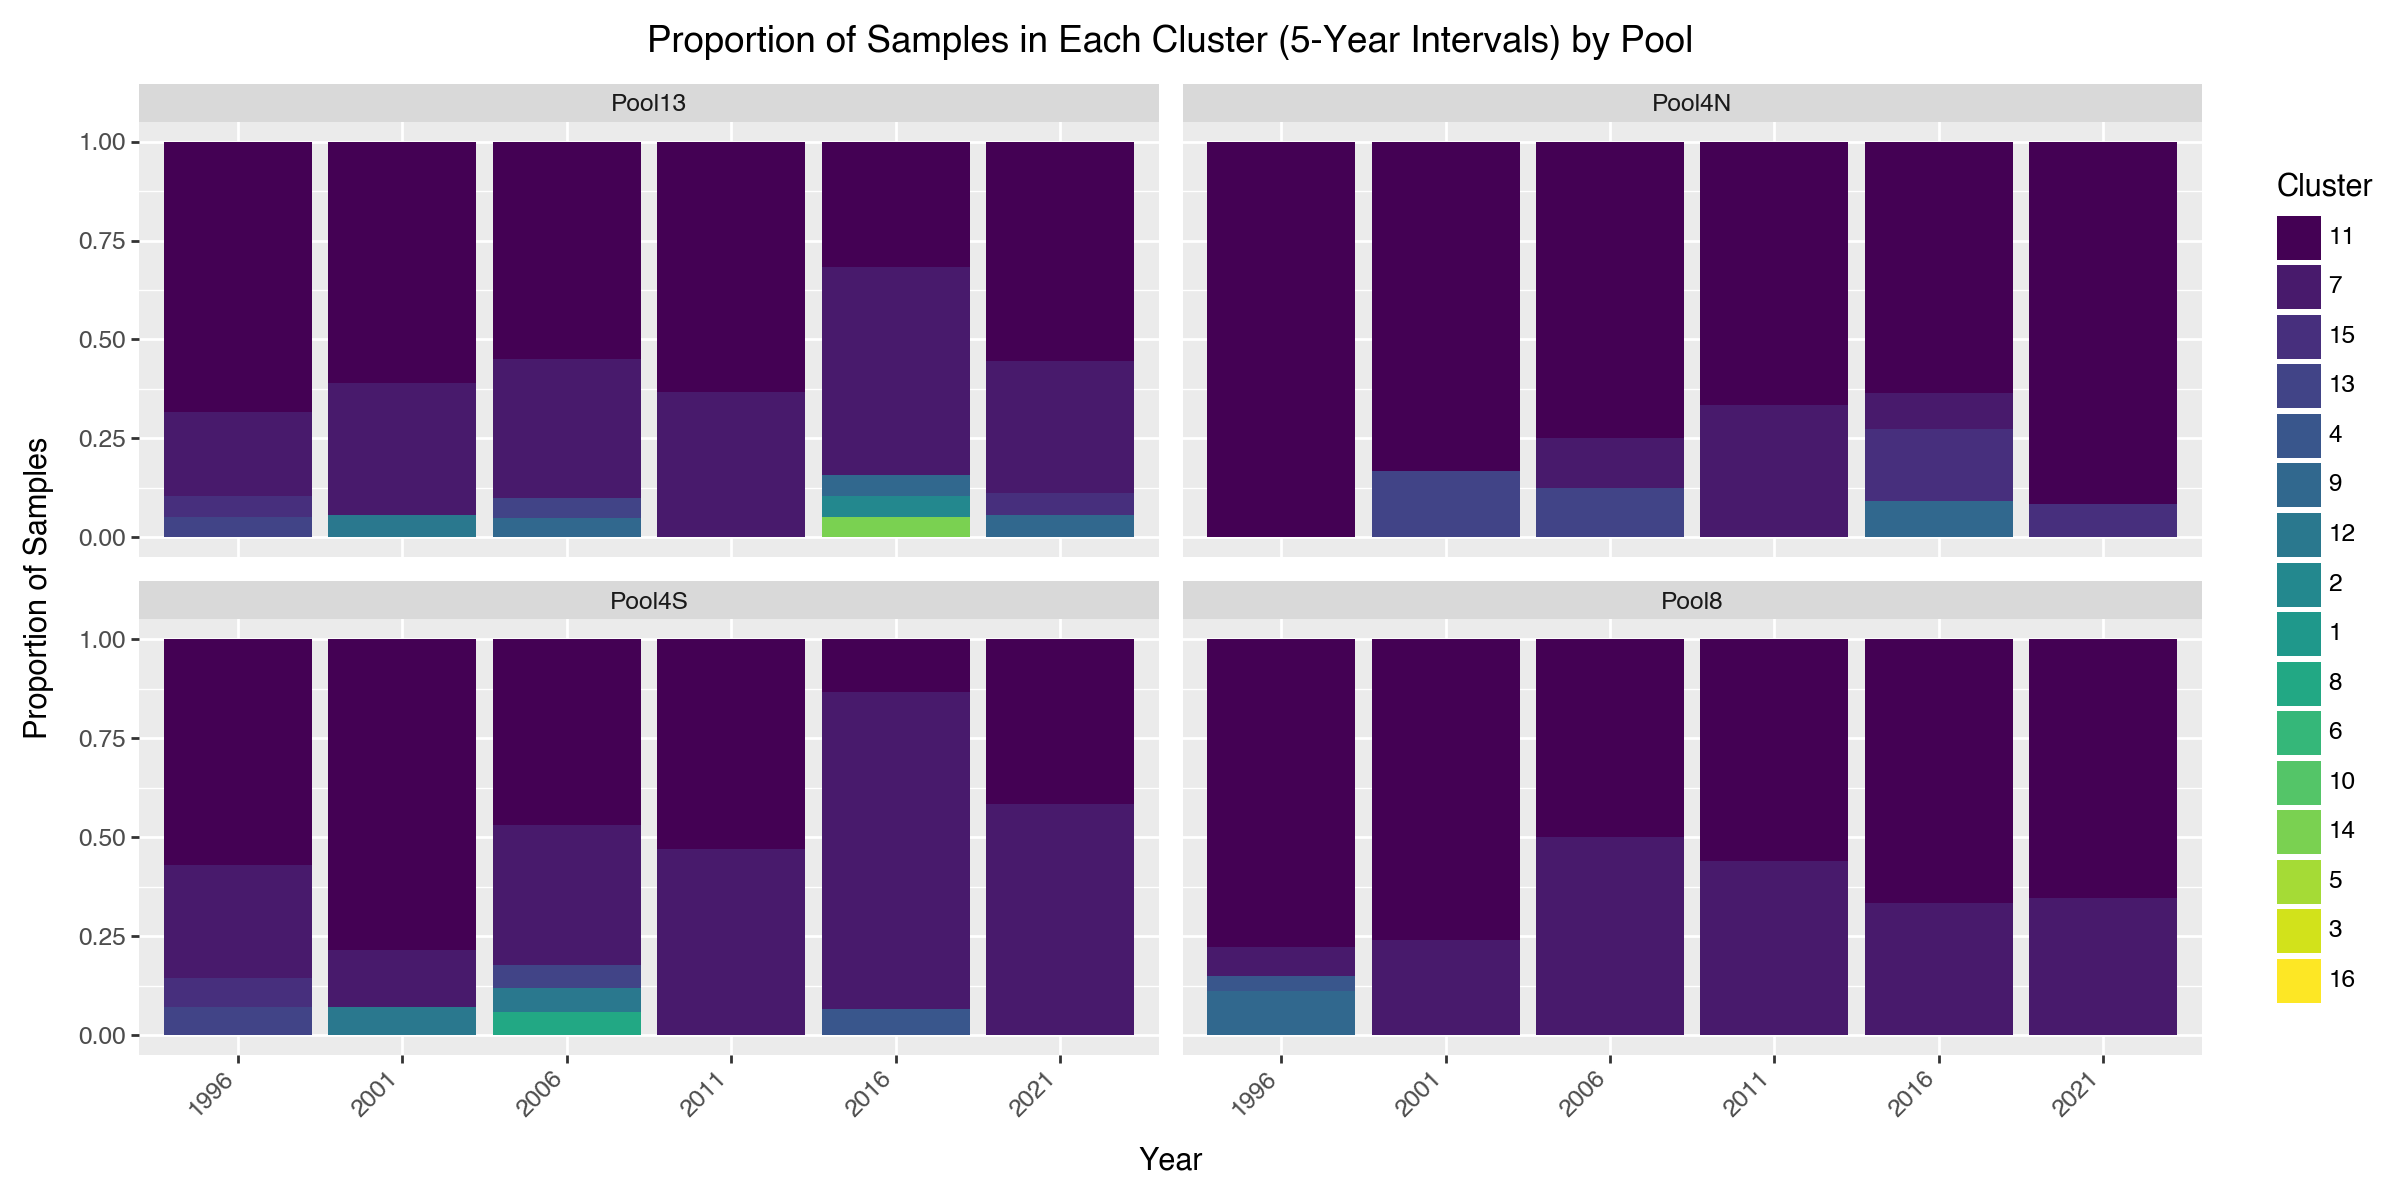

In [122]:
# ...existing code...
# Create a filtered dataset for specific years (1995, 2000, 2005, ...)
years_to_plot = list(range(1996, df_explo['year'].max() + 1, 5))

# Filter cluster_proportions for these years (copy to avoid SettingWithCopy warnings)
cluster_proportions_filtered = (
    cluster_proportions.loc[cluster_proportions['year'].isin(years_to_plot)].copy()
)

# Sort clusters by overall proportion (to create consistent ordering)
cluster_order = (
    cluster_proportions.groupby('cluster')['proportion']
    .sum()
    .sort_values(ascending=False)
    .index.astype(str)
)

# Ensure cluster is string and convert to categorical with specified order
cluster_proportions_filtered['cluster'] = pd.Categorical(
    cluster_proportions_filtered['cluster'].astype(str),
    categories=cluster_order,
    ordered=True
)

# Make year an ordered categorical so bars are chronological
cluster_proportions_filtered['year'] = pd.Categorical(
    cluster_proportions_filtered['year'],
    categories=years_to_plot,
    ordered=True
)

# Create stacked bar plot faceted by pool
from plotnine import *
(ggplot(cluster_proportions_filtered, aes(x='year', y='proportion', fill='cluster')) +
 geom_col(position='stack') +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Proportion of Samples', fill='Cluster',
      title='Proportion of Samples in Each Cluster (5-Year Intervals) by Pool') +
 theme(figure_size=(12, 6), axis_text_x=element_text(angle=45, hjust=1))
)
# ...existing code...

/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 65 rows containing missing values.


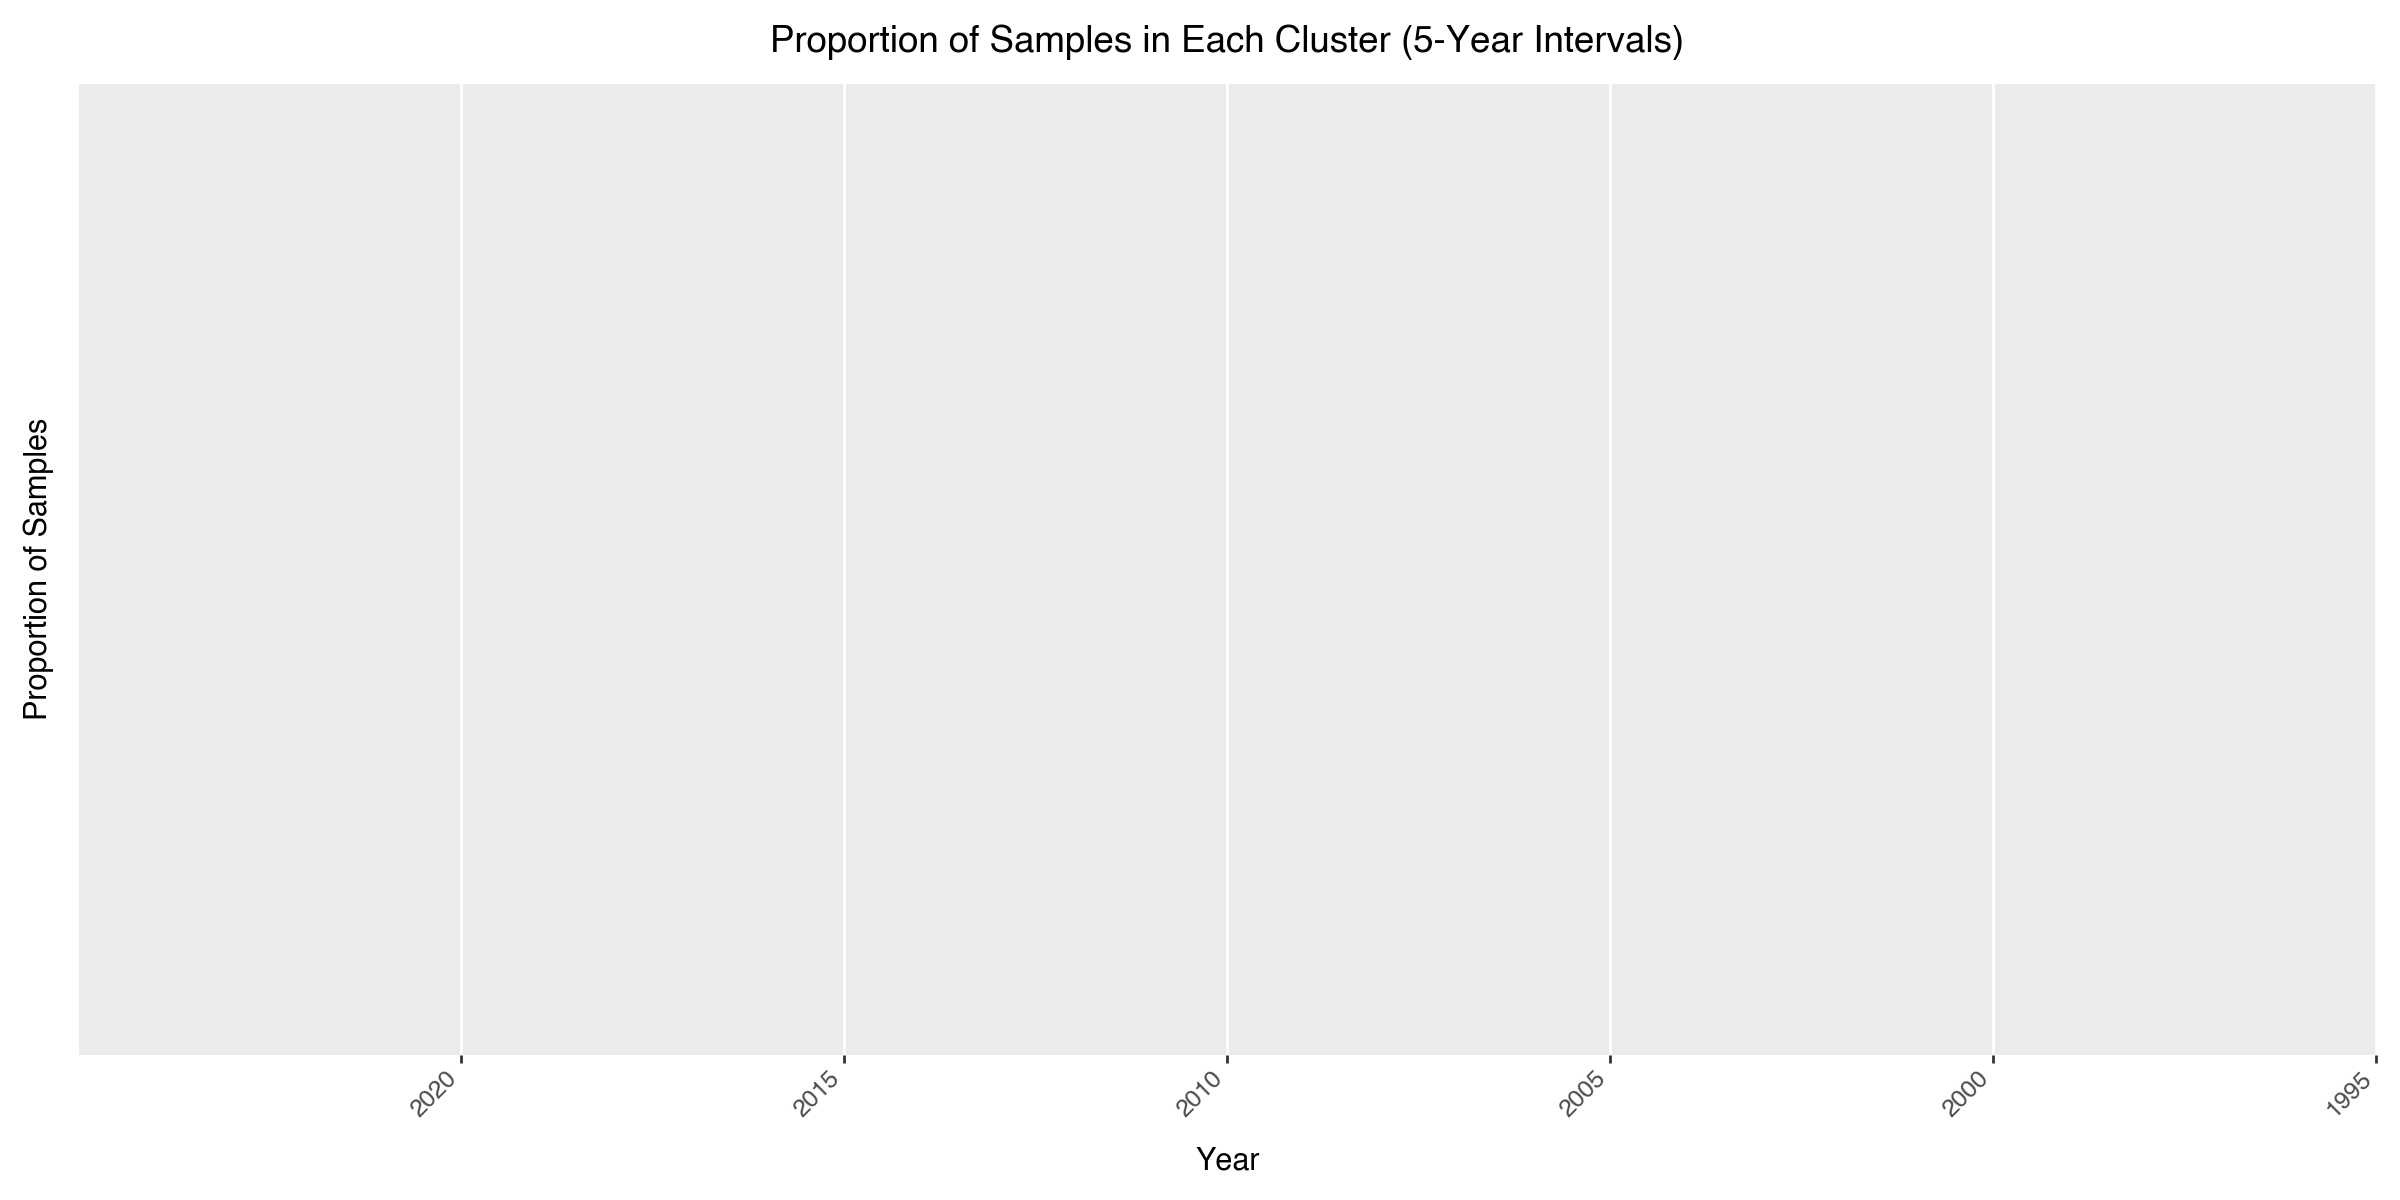

In [121]:
# ...existing code...
# Sort clusters by overall proportion (reverse order)
cluster_order = (
    cluster_proportions.groupby('cluster')['proportion']
    .sum()
    .sort_values(ascending=True)  # was descending
    .index.astype(str)
)

# Ensure cluster is string and convert to categorical with specified order
cluster_proportions_filtered['cluster'] = pd.Categorical(
    cluster_proportions_filtered['cluster'].astype(str),
    categories=cluster_order,
    ordered=True
)

# Create stacked bar plot with reversed x (years) order
from plotnine import *
(ggplot(cluster_proportions_filtered, aes(x='factor(year)', y='proportion', fill='cluster')) +
 geom_col(position='stack') +
 scale_x_discrete(limits=[str(y) for y in years_to_plot[::-1]]) +
 labs(x='Year', y='Proportion of Samples', fill='Cluster',
      title='Proportion of Samples in Each Cluster (5-Year Intervals)') +
 theme(figure_size=(12, 6), axis_text_x=element_text(angle=45, hjust=1))
)
# ...existing code...